In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import sys
import os
from  tensorflow import keras 
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate

In [3]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,22500,(227,227),include_targets=False,num_outputs = 100)

KeyboardInterrupt: 

In [ ]:
test_set = brevis.dataset.prepare.test_set(tf.keras.datasets.cifar100.load_data(label_mode="fine"),1,(227,227),include_targets=True,num_outputs = 100)

In [ ]:
#custom KL divergence fucnction
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    print("beta",beta)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    print("S_alpha",S_alpha)
    
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    print("S_beta",S_beta)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    print("lnB",lnB)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    print("lnB_uni",lnB_uni)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    print("dg0",dg0)
    dg1 = tf.compat.v1.digamma(alpha)
    print("dg1",dg1)
    
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10,modifier=1):
    #create a wrapper function that returns a function
    temperature = 1
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = brevis.utils.softplus_evidence(outputs)
        # print(evidence)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        # E = alpha - 1
        
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        # print(1-labels)
        print("evidence",evidence)
        print("max", np.amax(evidence),np.argmax(evidence),np.argmax(labels))
        
        alp = evidence*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp,num_outputs)
        print("C",C)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return (loss)
        # return (A + B) + C
    return  cross_entropy_evidence

In [ ]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
# train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,22500,(227,227),include_targets=True,num_outputs = 100)
# loss_fn = brevis.utils.evidence_crossentropy(num_outputs=100)
loss_fn = evidence_crossentropy(num_outputs=100, modifier=1)
model = brevis.BranchModel(name="./models/alexNetv6_cifar100.hdf5", custom_objects={})
# model.add_targets(100)
model.add_branches(branches.branch.newBranch_flatten_evidence,
                          ["max_pooling2d",
#                             "max_pooling2d_1",
#                             # "dense"
                          ],
                          target_input=True,loop=False,num_outputs=100)

model.compile(loss=loss_fn, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
# model.summary()

NameError: name 'tf' is not defined

In [38]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
X, _ = make_multilabel_classification(random_state=0)
print(X)
lda = LatentDirichletAllocation(n_components=5,
    random_state=0)
lda.fit(X)

# get topics for some given samples:
lda.transform(X[-2:])

[[3. 1. 4. ... 4. 1. 3.]
 [5. 0. 6. ... 0. 0. 3.]
 [3. 4. 1. ... 3. 2. 5.]
 ...
 [2. 1. 2. ... 1. 0. 3.]
 [6. 4. 1. ... 1. 3. 5.]
 [2. 4. 2. ... 5. 4. 2.]]


array([[0.00360392, 0.25499205, 0.0036211 , 0.64236448, 0.09541846],
       [0.15297572, 0.00362644, 0.44412786, 0.39568399, 0.003586  ]])

In [35]:
model.fit(test_set,1)

Setting Main Layers  and branch layers training to true
evidence tf.Tensor(
[[0.6932086  0.69326353 0.69500697 0.6957536  0.6945595  0.7195483
  0.694859   0.69473857 0.69535214 0.7002477  0.6941406  0.69446737
  0.7894019  0.6973021  0.6936594  0.69537556 0.6935124  0.6981845
  0.698019   0.6943262  0.69565856 0.69351816 0.6967807  0.7062573
  0.69707537 0.7132851  0.6978253  0.6967234  0.69397146 0.6941537
  0.6934824  0.6935453  0.69745076 0.69740343 0.6941683  0.6957355
  0.695095   0.69698256 0.6945988  0.6946482  0.6976653  0.6942533
  0.69372773 0.6946641  0.7046041  0.69483036 0.70593184 0.69346863
  0.6935438  0.6942716  0.6938152  0.69368476 0.6932483  0.6938426
  0.6988482  0.70045984 0.70638984 0.6954959  0.69418883 0.70081586
  0.69599545 0.6934514  0.6942638  0.6932817  0.69546354 0.7003356
  0.69404894 0.6940759  0.69796365 0.7018894  0.69410765 0.6961313
  0.69852537 0.69455343 0.6943404  0.6934949  0.69442606 0.701518
  0.6960195  0.7320876  0.6947738  0.70848066 0.699

KeyboardInterrupt: 

In [67]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:i], pred[:i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
        plt.tight_layout()
        plt.show()

In [116]:
def entropy(y):
    return tf.reduce_sum(y * log(y) )
    


stopping_point = 1
num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
print("outputs",num_outputs)
#     train_ds, test_ds, validation_ds = (dataset)
predictions = []
labels = []
pClass = []
predictions=[]
pEvidence = []
pUncertainty=[]
pOverlap=[]

Outputs = pd.DataFrame()
pAcc=[]
for i in range(num_outputs):
    pClass.append([])
    predictions.append([])
    pEvidence.append([])
    pUncertainty.append([])
    pAcc.append([])
    pOverlap.append([])
    # pOutputs.append([])

Results=[]
Pred=[]
Labels =[]

for i, (x,y) in enumerate(test_ds):
    if stopping_point and i > stopping_point:
        break
    print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
    predictions = model.predict(x)
    # print(predictions)
    # print(y)
    # if num_outputs > 1:
    #     for k, outputs in enumerate(predictions):
    #         for j, prediction in enumerate(outputs):
    #             # for pred
    #             Results.append(np.argmax(prediction))
    #             Pred.append(np.amax(prediction))
    #             Labels.append(np.argmax(y[j]))
    # else:
    for j, prediction in enumerate(predictions):
        # for pred
        Results.append(np.argmax(prediction))
        Pred.append(np.amax(prediction))
        Labels.append(np.argmax(y[j]))

# print(Results)
# print(Pred)
# print(Labels)
# print(set(Results).intersection(Labels))
df = pd.DataFrame({"x":Results,"y":Labels,"probs":Pred})
conditions = [df['x'] == df['y'],df['x'] != df['y']]

#define choices
choices = [1, 0]

#create new column in DataFrame that displays results of comparisons
df['testy'] = np.select(conditions, choices, default=None)


# df['testy'] = df.loc(df["x"] == df["y"])
    # print(i)
    # classDf = df.loc[(df['y'] == i)]

print(df)
# print(list(range(100)))
# plot_calibration_curve(Labels,Results,list(range(100)))

outputs 1
     x   y     probs testy
0   68  49  0.449199     0
1   37  33  0.354256     0
2   55  72  0.273053     0
3   72  51  0.526035     0
4   23  71  0.485064     0
..  ..  ..       ...   ...
59  69  69  0.761283     1
60  78  77  0.361278     0
61  44  27  0.367224     0
62  89  15  0.572325     0
63  38  65  0.857902     0

[64 rows x 4 columns]


In [109]:
# stopping_point = 1
# num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
# print("outputs",num_outputs)
# #     train_ds, test_ds, validation_ds = (dataset)
# predictions = []
# labels = []
# pClass = []
# predictions=[]
# pEvidence = []
# pUncertainty=[]
# pOverlap=[]

# Outputs = pd.DataFrame()
# pAcc=[]
# for i in range(num_outputs):
#     pClass.append([])
#     predictions.append([])
#     pEvidence.append([])
#     pUncertainty.append([])
#     pAcc.append([])
#     pOverlap.append([])
#     # pOutputs.append([])
# Results=[]
# Pred=[]
# Labels =[]
# for i, (x,y) in enumerate(test_set):
#     if stopping_point and i > stopping_point:
#         break
#     # print("prediction: {} of {}".format(i,len(test_set)),end='\r')
    
#     prediction = model.predict(x)
#     # print(prediction)
#     # print(prediction[0])
#     print(np.argmax(prediction))
#     print(np.argmax(prediction[0]))
#     Results.append(np.argmax(prediction))
#     Pred.append(np.amax(prediction))
#     Labels.append(np.argmax(y))
    
# print(Results)
# print(Pred)
# print(Labels)
# # print(set(Results).intersection(Labels))
# df = pd.DataFrame({"x":Results,"y":Labels,"probs":Pred})
# conditions = [df['x'] == df['y'],df['x'] != df['y']]

# #define choices
# choices = [1, 0]

# #create new column in DataFrame that displays results of comparisons
# df['testy'] = np.select(conditions, choices, default=None)


# # df['testy'] = df.loc(df["x"] == df["y"])
#     # print(i)
#     # classDf = df.loc[(df['y'] == i)]

# print(df)
# # print(list(range(100)))
# # plot_calibration_curve(Labels,Results,list(range(100)))

outputs 1
68
68
37
37
[68, 37]
[0.4491988, 0.35425586]
[49, 33]
    x   y     probs testy
0  68  49  0.449199     0
1  37  33  0.354256     0


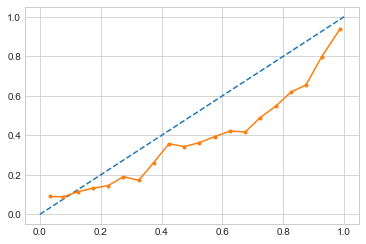

In [104]:
# SVM reliability diagram with calibration
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# generate 2 class dataset
# X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# # split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# # fit a model
# _model = SVC(gamma='scale')
# calibrated = CalibratedClassifierCV(_model, method='sigmoid', cv=5)
# calibrated.fit(trainX, trainy)
# # predict probabilities
# probs = calibrated.predict_proba(testX)[:, 1]
# # reliability diagram
# print(probs)
# print(testy)
fop, mpv = calibration_curve(df['testy'].tolist(), df['probs'].tolist(), n_bins=20, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [53]:
model.fit(train_ds, epochs= 1,transfer=False)

Setting Main Layers  and branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 11.6557 - exit_loss: 3.9281 - branch_softmax_13_loss: 3.9371 - branch_softmax_14_loss: 3.7905 - exit_accuracy: 0.7615 - branch_softmax_13_accuracy: 0.1240 - branch_softmax_14_accuracy: 0.1508 - branch_softmax_13_evidence: 0.9230 - branch_softmax_13_mean_ev_succ: 100.5892 - branch_softmax_13_mean_ev_fail: 90.4259 - branch_softmax_14_evidence: 0.9423 - branch_softmax_14_mean_ev_succ: 105.0561 - branch_softmax_14_mean_ev_fail: 91.5269
Epoch 1: saving model to models\alexnet_branched.hdf5.hdf5
1406/1406 [==============================] - 220s 145ms/step - loss: 11.6557 - exit_loss: 3.9281 - branch_softmax_13_loss: 3.9371 - branch_softmax_14_loss: 3.7905 - exit_accuracy: 0.7615 - branch_softmax_13_accuracy: 0.1240 - branch_softmax_14_accuracy: 0.1508 - branch_softmax_13_evidence: 0.9230 - branch_softmax_13_mean_ev_succ: 100.5892 - branch_softmax_13_mean_ev_fail: 90.4259 - bra

In [54]:
#first round
outputs = brevis.evaluate.collectEvidence_branches(model, test_set, evidence=True,stopping_point=1000)
thresholds=[]
for i, Predictions in enumerate(outputs):
            thresholds.append(brevis.evaluate.threshold_fn(Predictions))
print(thresholds)


outputs 3
[16.375316619873047, 4.61843204498291, 5.065972328186035, 6.690911769866943, 0.0, 0.0, 0.0, 0.9248687624931335, 0.0, 92.48687744140625, 0.866499125957489, 0.0, 86.64990997314453]
[12.300217628479004, 4.617344856262207, 4.760553359985352, 2.9223194122314453, 0.0, 0.0, 0.0, 0.844154953956604, 0.0, 84.41549682617188, 0.909829318523407, 0.0, 90.9829330444336]
Doneiction: 1000 of 10000
[0.0, 1.2391349770638753, 1.3007000511719378]


mean 1.0626568199878328  std 0.21703343505538292
threshold 1.2391349770638753
rollover Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,
            ...
             988,  989,  991,  992,  993,  994,  995,  996,  999, 1000],
           dtype='int64', length=817)
rollover enabled, 817 predictions provided
mean 1.0712894540858933  std 0.19553904398246286
threshold 1.3007000511719378
rollover Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,
            ...
             988,  989,  991,  992,  993,  994,  995,  996,  999, 1000],
           dtype='int64', length=745)
rollover enabled, 745 predictions provided
mean 0.0  std 0.0
threshold 0.0
rollover Int64Index([], dtype='int64')


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

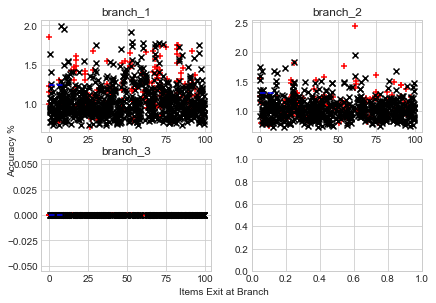

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,1001,0.162837,0.162837,1.239135,0.183816,66,118,0.358696,0.646739,65,9,53
1,branch_2,817,0.219780,0.186047,1.300700,0.088127,21,51,0.291667,0.625000,27,4,24
2,branch_3,745,0.487512,0.432215,0.000000,1.000000,322,423,0.432215,inf,0,0,423


In [55]:
#with A+b  
displayEvidence_cascade(outputs,thresholds)

mean 0.0022588221393630005  std 0.003679865558367367
threshold 0.006049274423832242
rollover Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
            ...
             990,  991,  992,  993,  994,  995,  997,  998,  999, 1000],
           dtype='int64', length=929)
rollover enabled, 929 predictions provided
mean 0.0013916520499662965  std 0.0012759580888002308
threshold 0.0030778754664764797
rollover Int64Index([   0,    1,    2,    3,    6,    7,    8,   11,   12,   14,
            ...
             990,  991,  992,  993,  994,  995,  997,  998,  999, 1000],
           dtype='int64', length=808)
rollover enabled, 808 predictions provided
mean 0.0  std 0.0
threshold 0.0
rollover Int64Index([], dtype='int64')


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

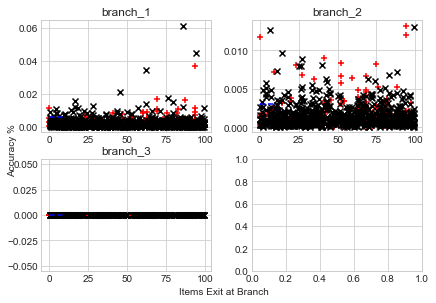

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,1001,0.173826,0.173826,0.006049,0.071928,20,52,0.277778,0.708333,21,2,31
1,branch_2,929,0.211788,0.202368,0.003078,0.130248,34,87,0.280992,0.710744,35,4,52
2,branch_3,808,0.510490,0.503713,0.000000,1.000000,407,401,0.503713,inf,0,0,401


In [40]:
#with modifier 2 
displayEvidence_cascade(outputs,thresholds)

mean 0.0041722012093500975  std 0.006337333229150103
threshold 0.011751121900380176
rollover Int64Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   10,
            ...
             990,  991,  992,  993,  994,  995,  997,  998,  999, 1000],
           dtype='int64', length=911)
rollover enabled, 911 predictions provided
mean 0.020074807602371868  std 0.019572065265276488
threshold 0.04989886120443738
rollover Int64Index([   0,    2,    3,    5,    6,    7,    8,    9,   10,   11,
            ...
             990,  991,  992,  993,  994,  995,  997,  998,  999, 1000],
           dtype='int64', length=820)
rollover enabled, 820 predictions provided
mean 0.0  std 0.0
threshold 0.0
rollover Int64Index([], dtype='int64')


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

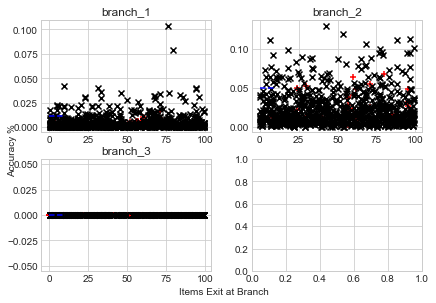

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,1001,0.034965,0.034965,0.011751,0.08991,1,89,0.011111,0.622222,34,0,55
1,branch_2,911,0.035964,0.039517,0.049899,0.09989,4,87,0.043956,0.703297,27,2,60
2,branch_3,820,0.406593,0.418293,0.000000,1.00000,343,477,0.418293,inf,0,0,477


In [37]:
#with modifier 1

displayEvidence_cascade(outputs,thresholds)

In [ ]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
loss_fn = evidence_crossentropy(num_outputs=100, modifier=2)
model = brevis.BranchModel(name="./models/alexNetv6_cifar100.hdf5", custom_objects={})
model.add_branches(branches.branch.newBranch_flatten_evidence,
                          ["max_pooling2d",
                            # "max_pooling2d_1",
                            # "dense"
                          ],
                          target_input=True,loop=False,num_outputs=100)
model.compile(loss=loss_fn, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
# model.summary()
model.fit(train_ds, epochs= 1,transfer=True)
#second round
model.evaluate(test_ds)
# outputs = brevis.evaluate.collectEvidence_branches(model, test_set, evidence=True,stopping_point=10000)
# thresholds=[]
# for i, Predictions in enumerate(outputs):
#             thresholds.append(brevis.evaluate.threshold_fn(Predictions))
# print(thresholds)
# displayEvidence_cascade(outputs,thresholds)


preset: Other
targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  max_pooling2d
[<KerasTensor: shape=(None, 227, 227, 3) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'targets')>]
[<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'exit')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'branch_softmax_1')>]
branch added <brevis.core_v2.BranchModel object at 0x00000154B43D0DC8>

preset: Other
Freezing Main Layers and setting branch layers training to true
1406/1406 [==============================] - ETA: 0s - loss: 11.3526 - exit_loss: 9.1173 - branch_softmax_1_loss: 2.2353 - exit_accuracy: 0.7861 - branch_softmax_1_accuracy: 0.0916 - branch_softmax_1_evidence: 0.0202 - branch_softmax_1_mean_ev_succ: 0.7270 - branch_softmax_1_mean_ev_fail: 2.0193
Epoch 1: saving model to models\alexnet_branched.hdf5.hdf5
312/

[11.118846893310547,
 9.25614070892334,
 1.862705111503601,
 0.5144230723381042,
 0.14182692766189575,
 0.0023055225610733032,
 0.23045571148395538,
 0.23106972873210907]

outputs 2
[11.504583358764648, 9.553993225097656, 1.9505903720855713, 0.0, 0.0, 0.0002988429623655975, 0.0, 0.029884295538067818]
[12.486100196838379, 9.551654815673828, 2.934445381164551, 0.0, 0.0, 0.005255298689007759, 0.0, 0.5255298614501953]
Doneiction: 9999 of 10000
[0.0, 0.00720635624010443]
mean 0.002180268421144953  std 0.00458043660139588
threshold 0.00720635624010443
rollover Int64Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   10,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=9290)
rollover enabled, 9290 predictions provided
mean 0.0  std 0.0
threshold 0.0
rollover Int64Index([], dtype='int64')


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

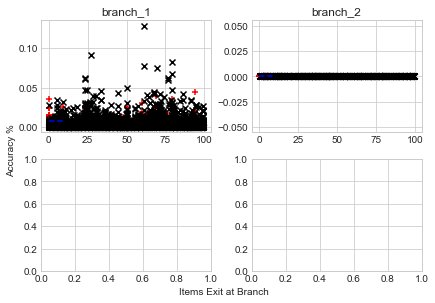

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.1418,0.141800,0.007206,0.071,114,596,0.160563,0.628169,264,18,332
1,branch_2,9290,0.5144,0.514962,0.000000,1.000,4784,4506,0.514962,inf,0,0,4506


In [17]:
outputs = brevis.evaluate.collectEvidence_branches(model, test_set, evidence=True,stopping_point=10000)
thresholds=[]
for i, Predictions in enumerate(outputs):
            thresholds.append(brevis.evaluate.threshold_fn(Predictions))
print(thresholds)
displayEvidence_cascade(outputs,thresholds)

mean 0.0023021544295097913  std 0.003594945580005754
threshold 0.007776629760166837
rollover Int64Index([   0,    1,    2,    3,    5,    7,    8,    9,   10,   11,
            ...
             991,  992,  993,  994,  995,  996,  997,  998,  999, 1000],
           dtype='int64', length=940)
rollover enabled, 940 predictions provided
mean 0.0  std 0.0
threshold 0.0
rollover Int64Index([], dtype='int64')


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

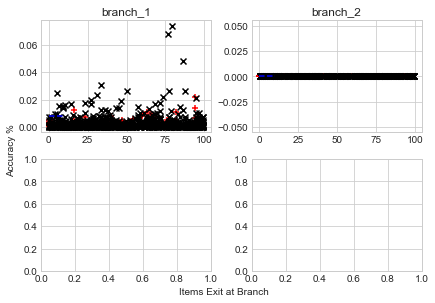

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,1001,0.143856,0.143856,0.007777,0.060939,9,52,0.147541,0.655738,21,1,31
1,branch_2,940,0.516484,0.519149,0.000000,1.000000,488,452,0.519149,inf,0,0,452


In [11]:
displayEvidence_cascade(outputs,thresholds)

outputs 2
[16.987812042236328, 11.873551368713379, 5.114260673522949, 0.0, 0.0, 0.0007315719849430025, 0.0, 0.07315719872713089]
[15.522699356079102, 11.762887954711914, 3.7598116397857666, 0.0, 0.0, 0.008181844837963581, 0.0, 0.818184494972229]
Doneiction: 1000 of 10000
[0.0, 0.007970994856068263]
      label  evidence  Acc  overlap
0        49  0.000732  0.0      0.0
1        33  0.008182  0.0      0.0
2        72  0.004377  0.0      0.0
3        51  0.003166  0.0      0.0
4        71  0.004437  0.0      1.0
...     ...       ...  ...      ...
996      36  0.007027  0.0      0.0
997       9  0.000213  0.0      0.0
998      53  0.001478  1.0      0.0
999      91  0.001751  1.0      0.0
1000     65  0.001242  0.0      0.0

[1001 rows x 4 columns]
mean 0.0033646938494920255  std 0.0049514688916248465
[0.007970994856068263, 0.0]
threshold 0.007970994856068263
rollover Int64Index([   0,    2,    3,    4,    5,    7,    8,   10,   11,   12,
            ...
             991,  992,  993,  99

C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

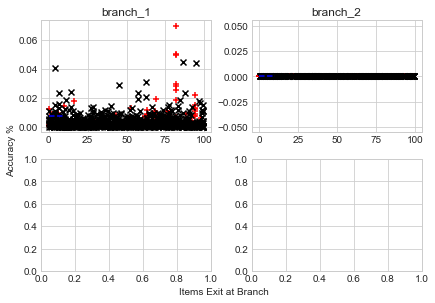

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,1001,0.156843,0.156843,0.007971,0.120879,31,90,0.256198,0.735537,32,4,58
1,branch_2,880,0.504496,0.506818,0.000000,1.000000,446,434,0.506818,inf,0,0,434


In [8]:
outputs = brevis.evaluate.collectEvidence_branches(model, test_set, evidence=True,stopping_point=1000)
thresholds=[]
for i, Predictions in enumerate(outputs):
            thresholds.append(brevis.evaluate.threshold_fn(Predictions))
print(thresholds)

displayEvidence_cascade(outputs,thresholds)

In [ ]:
model.fit(train_ds,validation_ds, epochs= 1,transfer=True)

Freezing Main Layers and setting branch layers training to true
 983/1406 [===================>..........] - ETA: 37s - loss: 11.4967 - exit_loss: 9.1231 - branch_softmax_3_loss: 2.3736 - exit_accuracy: 0.7821 - branch_softmax_3_accuracy: 0.0830 - branch_softmax_3_evidence: 0.0286 - branch_softmax_3_mean_ev_succ: 0.9664 - branch_softmax_3_mean_ev_fail: 2.8701

In [ ]:
# loss_fn = brevis.utils.evidence_crossentropy(num_outputs=100)
loss_fn = evidence_crossentropy(num_outputs=100,modifier=1)
model = brevis.BranchModel(name="./models/alexNetv6_cifar100.hdf5", custom_objects={})
model.add_targets(100)
model.add_branches(branches.branch.newBranch_flatten_evidence,
                          ["max_pooling2d",
                            # "max_pooling2d_1",
                            # "dense"
                          ],
                          target_input=True,loop=False,num_outputs=100)

model.compile(loss=loss_fn, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
# model.summary()
model.fit(train_ds,validation_ds, epochs= 1,transfer=True)

In [3]:
loss_fn = brevis.utils.evidence_crossentropy(num_outputs=100)
model = brevis.BranchModel(name="./models/alexnet_branched.hdf5.hdf5")
model.compile(loss=loss_fn, optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
model.summary()


preset: Other

preset: Other
Model: "alexnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 55, 55, 96)   34944       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 55, 55, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                              

NameError: name 'test_ds' is not defined

In [22]:
test_set = brevis.dataset.prepare.test_set(tf.keras.datasets.cifar100.load_data(label_mode="fine"),1,(227,227),include_targets=True,num_outputs = 100)
model.evaluate_branch_thresholds(test_set,stopping_point=10000)

targetsis : True
adding targets to inputs
outputs 4
[19.94405746459961, 11.890739440917969, 1.7371482849121094, 2.8814213275909424, 3.4347476959228516, 0.0, 0.0, 0.0, 0.0, 0.000702149816788733, 0.0, 0.07021497935056686, 0.00025197453214786947, 0.0, 0.025197451934218407, 0.00014449986338149756, 0.0, 0.01444998662918806]
[23.40973472595215, 11.809062957763672, 2.964844226837158, 3.5923893451690674, 5.043437957763672, 0.0, 0.0, 0.0, 0.0, 0.010879354551434517, 0.0, 1.087935447692871, 0.0002039599057752639, 0.0, 0.02039599046111107, 3.1652365578338504e-05, 0.0, 0.003165236674249172]


KeyboardInterrupt: 

In [23]:
outputs = brevis.evaluate.collectEvidence_branches(model, test_set, evidence=True,stopping_point=10000)

outputs 4
[19.94405746459961, 11.890739440917969, 1.7371482849121094, 2.8814213275909424, 3.4347476959228516, 0.0, 0.0, 0.0, 0.0, 0.000702149816788733, 0.0, 0.07021497935056686, 0.00025197453214786947, 0.0, 0.025197451934218407, 0.00014449986338149756, 0.0, 0.01444998662918806]
[23.40973472595215, 11.809062957763672, 2.964844226837158, 3.5923893451690674, 5.043437957763672, 0.0, 0.0, 0.0, 0.0, 0.010879354551434517, 0.0, 1.087935447692871, 0.0002039599057752639, 0.0, 0.02039599046111107, 3.1652365578338504e-05, 0.0, 0.003165236674249172]
Doneiction: 9999 of 10000


In [24]:
thresholds=[]
for i, Predictions in enumerate(outputs):
            thresholds.append(brevis.evaluate.threshold_fn(Predictions))
print(thresholds)

      label  evidence  Acc  overlap
0        49         0  0.0      0.0
1        33         0  0.0      0.0
2        72         0  0.0      0.0
3        51         0  0.0      0.0
4        71         0  1.0      0.0
...     ...       ...  ...      ...
9995     83         0  0.0      0.0
9996     14         0  1.0      0.0
9997     51         0  1.0      0.0
9998     42         0  0.0      0.0
9999     70         0  1.0      0.0

[10000 rows x 4 columns]
      label  evidence  Acc  overlap
0        49  0.000702  0.0      0.0
1        33  0.010879  0.0      0.0
2        72  0.002026  0.0      0.0
3        51  0.004428  0.0      0.0
4        71  0.002924  1.0      0.0
...     ...       ...  ...      ...
9995     83  0.000625  0.0      0.0
9996     14  0.004423  0.0      1.0
9997     51  0.000430  0.0      1.0
9998     42  0.009564  0.0      0.0
9999     70  0.001534  0.0      1.0

[10000 rows x 4 columns]
      label  evidence  Acc  overlap
0        49  0.000252  0.0      0.0
1        33 

In [14]:

def displayEvidence_cascade(branch_predictions, thresholds=None, output_names=["branch_1","branch_2","branch_3","Main_Exit"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    #lets reorder the predictions so that the final layer is at the end
    # _branch_predictions.copy()
    _branch_predictions = branch_predictions.copy()
    # print(_branch_predictions)
    _branch_predictions.append(_branch_predictions.pop(0))
    
    if thresholds is not None and thresholds[0]==0:
        _thresholds = thresholds.copy()
        # print(_branch_predictions)
        _thresholds.append(_thresholds.pop(0))
    
    rollOver_indices = pd.Index([])
    for i, Predictions in enumerate(_branch_predictions):
        # print(Predictions)
        acc = pd.Series([0,0],[True,False]) ##set defaults 
        acc.update(Predictions["Acc"].value_counts())
        #check if rollover is active, if so, select only the predictions whose indexes match the rollover list
        # print(rollOver_indices)
        test_acc = pd.Series([0,0],[True,False]) ##set defaults 
        test_acc.update(Predictions["Acc"].astype('bool').value_counts())

        test_accuracy = (test_acc.loc[True] /  (test_acc.loc[True] + test_acc.loc[False]))
        if len(rollOver_indices)>0:
            print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
            Predictions = Predictions.iloc[rollOver_indices]
        # print(Predictions.shape)
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = pd.Series([0,0],[True,False]) ##set defaults 
        acc.update(Predictions["Acc"].value_counts())


        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        _Incorrects_missed = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["overlap"] == 1)] #all the predictions that the main exit got true and the branch got wrong
        if len(_Incorrects_missed) > 0 :
            mean = _Incorrects_missed.groupby("Acc")["evidence"].mean().iloc[0]
            std = _Incorrects_missed.groupby("Acc")["evidence"].std().iloc[0]
        else:
            mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
            std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]

        print("mean",mean , " std",std)
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        
        E_threshold = -1 #-1 is null for threshold
        # print(_thresholds)
        if _thresholds is not None:
            try:
                if type(_thresholds) is list:
                    E_threshold = _thresholds[i]
                else:
                    E_threshold = _thresholds
                print("threshold", E_threshold)
                if Evidence:
                    Accepted = Predictions.loc[(Predictions["evidence"] >= E_threshold)]
                    Rejected = Predictions.loc[(Predictions["evidence"] < E_threshold)]
                else: 
                    Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
                    Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
            except:
                print("threshold not supplied for branch {}, using test data".format(i))
        else:       
            if Evidence:
                if E_threshold ==-1:
                    E_threshold = mean + std
                Accepted = Predictions.loc[(Predictions["evidence"] >= E_threshold)]
                Rejected = Predictions.loc[(Predictions["evidence"] < E_threshold)]
            else: 
                if E_threshold ==-1:
                    E_threshold = mean - std
                Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
                Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
        
        rollOver_indices = Rejected.index
        print("rollover", rollOver_indices)
        Incorrects_overlap = Accepted.loc[(Accepted['Acc'] == False) & (Accepted["overlap"] == 0)].count().iloc[0]
        # print("accepted", Accepted, Accepted.shape)
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Predictions": len(Predictions.index),
                "test_accuracy": test_accuracy,
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Accepted.shape[0]/(Predictions.shape[0]),
                "accepted_correct":Accepted.loc[(Predictions['Acc'] == True)].shape[0],
                "accepted_incorrect":Accepted.loc[(Predictions['Acc'] == False)].shape[0],
                "accepted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].shape[0])/ Accepted.shape[0],
                "overlap_adjusted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].count()[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] >E_threshold)].count()[0],
                "M(T) B(F)":Accepted.loc[(Accepted["overlap"] == 1)].count().iloc[0],
                "M(F) B(T)":Accepted.loc[(Accepted["overlap"] ==-1)].count().iloc[0],
                "M(F) B(F) overlap":Incorrects_overlap,
                },index=[i]))
#         print("TT",Accepted.loc[(Accepted["Acc"] ==True) & (Accepted["overlap"] == 0)])
#         print("TF",Accepted.loc[(Accepted["overlap"] == 1)])
#         print("FT",Accepted.loc[(Accepted["overlap"] == -1)])
#         print("FF",Accepted.loc[(Accepted["Acc"] ==False) & (Accepted["overlap"] == 0)])
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text(output_names[i])
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

# displayEvidence_cascade(outputs,thresholds)

C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

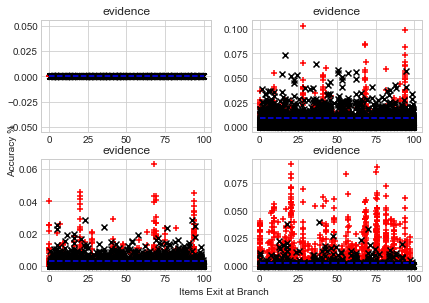

,Branch Name,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,rejected_correct,rejected_incorrect,Incorrects_overlap
0,0.000000,0.4689,0.000000,0.0000,0,0,NaN,NaN,0,0,0
1,0.009517,0.2176,0.009517,0.1165,341,824,0.292704,0.769099,1835,7000,555
2,0.002986,0.2389,0.002986,0.1094,456,638,0.416819,0.799817,1933,6973,419
3,0.002120,0.4153,0.002120,0.1423,1198,225,0.841883,0.959944,2955,5622,168


In [26]:
def displayEvidence(branch_predictions, output_names=["main_exit","branch_1","branch_2","branch_3"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    for i, Predictions in enumerate(branch_predictions):

        acc = pd.Series([0,0],[True,False]) ##set defaults 
        acc.update(Predictions["Acc"].astype('bool').value_counts())

        mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
        std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        if Evidence:
            E_threshold = mean + std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        else:
            print("mean",mean , " std",std)
            E_threshold = mean - std
            Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
            # if i ==1 or i == 0 :
                # print(Predictions)
                # print(Predictions.loc[ (Predictions['Acc'] == True)  & (Predictions["overlap"] == 0) ])
            # print(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold) ].count())
            Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                    "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                    "E_Threshold":E_threshold,
                    # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[i]))
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,101),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text("evidence")
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

def eval_branches( model, dataset, count = 1, options="accuracy"):
    """ evaulate func for checking how well a branched model is performing.
        function may be moved to eval_model.py in the future.
    """ 
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels

    (train_images, train_labels), (test_images, test_labels) = dataset
    
    print("ALEXNET {}".format(brevis.ALEXNET))
    if BranchingDnn.ALEXNET:
        train_ds, test_ds, validation_ds = prepare.prepareAlexNetDataset(dataset,32)                       
    else: 
        test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
        test_ds_size = len(list(test_ds))
        test_ds =  (test_ds
            .batch(batch_size=64, drop_remainder=True))
    
    if BranchingDnn.ALEXNET: 
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
    else:
        model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

    run_logdir = get_run_logdir(model.name)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir +"/eval")

    if options == "accuracy":
        test_scores = model.evaluate(test_ds, verbose=2)
        printTestScores(test_scores,num_outputs)
    elif options == "entropy":
        if BranchingDnn.ALEXNET:
            train_ds, test_ds, validation_ds = prepare.prepareAlexNetDataset(dataset,1)                       
        else: 
            test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
            test_ds_size = len(list(test_ds))
            test_ds =  (test_ds
                # .map(augment_images)
                # .shuffle(buffer_size=int(test_ds_size))
                .batch(batch_size=1, drop_remainder=True))
    
        iterator = iter(test_ds)
        item = iterator.get_next()
        results = model.predict(item[0])

        for output in results:
            for result in output: 
                print(result)
                Pclass = np.argmax(result)
                print("predicted class:{}, actual class: {}".format(Pclass, item[1]))

                for softmax in result:
                    entropy = calcEntropy(softmax)
                    print("entropy:{}".format(entropy))
        print("answer: {}".format(item[1]))
        # results = calcEntropy(y_hat)
        # print(results)
        pass
    elif options == "throughput":
        if BranchingDnn.ALEXNET:
            train_ds, test_ds, validation_ds = prepare.prepareAlexNetDataset(dataset,1)                       
        else: 
            test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
            test_ds_size = len(list(test_ds))
            test_ds =  (test_ds
                # .map(augment_images)
                # .shuffle(buffer_size=int(test_ds_size))
                .batch(batch_size=1, drop_remainder=True))
    
        iterator = iter(test_ds)
        item = iterator.get_next()
        pred=[]
        labels=[]
        for i in range(len(test_ds)):
            pred.append(model.predict(item[0]))
            labels.append(item[1])
        
        results = throughputMatrix(pred, labels, numOutput)
        print(results)
        print(pd.DataFrame(results).T)
        pass


    return 

displayEvidence(outputs,thresholds)